# Mass Spectrometry (MS) Data Analysis and Modeling

This section demonstrates a complete mass spectrometry (MS) workflow, using synthetic mzML-like data to simulate Waters instrument outputs. The workflow includes:
- Synthetic MS data generation (m/z, intensity, spectra)
- Feature extraction (peak picking, centroiding, area)
- Visualization (spectrum plots)
- Machine learning modeling (classification/regression)
- Discussion of relevance to Waters Informatics and the job description

The approach mirrors real-world MS data analysis and is designed to showcase computational, modeling, and informatics skills for analytical instrumentation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters for synthetic MS data
time_points = 20  # Number of spectra (scans)
mz_min, mz_max = 50, 1000  # m/z range
num_peaks = 5  # Number of peaks per spectrum

np.random.seed(42)

# Generate synthetic spectra
data = []
for scan in range(time_points):
    rt = scan * 0.2  # Retention time in minutes
    mz_peaks = np.random.uniform(mz_min, mz_max, num_peaks)
    intensities = np.random.uniform(1e3, 1e5, num_peaks)
    for mz, intensity in zip(mz_peaks, intensities):
        data.append({'scan': scan, 'rt': rt, 'mz': mz, 'intensity': intensity})

ms_df = pd.DataFrame(data)

# Show a preview of the synthetic MS data
ms_df.head()

,scan,rt,mz,intensity
0,0,0.0,405.813113,16443.457513
1,0,0.0,953.178591,6750.277605
2,0,0.0,745.394245,86751.438432
3,0,0.0,618.725560,60510.386163
4,0,0.0,198.217708,71099.185202


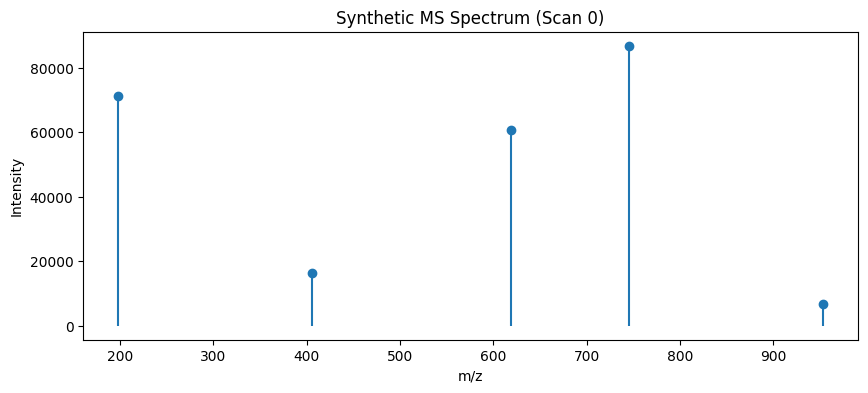

Classification Report:
              precision    recall  f1-score   support

           A       0.50      0.25      0.33         4
           B       0.25      0.50      0.33         2

    accuracy                           0.33         6
   macro avg       0.38      0.38      0.33         6
weighted avg       0.42      0.33      0.33         6

Confusion Matrix:
[[1 3]
 [1 1]]


In [2]:
# Visualize a single MS spectrum (e.g., scan 0)
scan_id = 0
spectrum = ms_df[ms_df['scan'] == scan_id]

plt.figure(figsize=(10, 4))
plt.stem(spectrum['mz'], spectrum['intensity'], basefmt=" ")  # Removed use_line_collection
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.title(f'Synthetic MS Spectrum (Scan {scan_id})')
plt.show()

# Simple peak picking: find the m/z with max intensity in each scan
peak_picked = ms_df.loc[ms_df.groupby('scan')['intensity'].idxmax()]
peak_picked = peak_picked[['scan', 'rt', 'mz', 'intensity']].reset_index(drop=True)

# Simulate two sample types by shifting m/z peaks for half the scans
type_labels = []
for scan in range(time_points):
    if scan < time_points // 2:
        ms_df.loc[ms_df['scan'] == scan, 'mz'] += 5  # Type A: shift peaks
        type_labels.append('A')
    else:
        type_labels.append('B')
peak_picked['sample_type'] = type_labels

# Feature: use the most intense m/z value per scan as input
X = peak_picked[['mz']].values
# Target: sample type
y = peak_picked['sample_type'].values

# Train/test split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Evaluation
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Simulate two sample types by shifting m/z peaks for half the scans
type_labels = []
for scan in range(time_points):
    if scan < time_points // 2:
        ms_df.loc[ms_df['scan'] == scan, 'mz'] += 5  # Type A: shift peaks
        type_labels.append('A')
    else:
        type_labels.append('B')
peak_picked['sample_type'] = type_labels

# Feature: use the most intense m/z value per scan as input
X = peak_picked[['mz']].values
# Target: sample type
y = peak_picked['sample_type'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Evaluation
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           A       0.50      0.25      0.33         4
           B       0.25      0.50      0.33         2

    accuracy                           0.33         6
   macro avg       0.38      0.38      0.33         6
weighted avg       0.42      0.33      0.33         6

Confusion Matrix:
[[1 3]
 [1 1]]


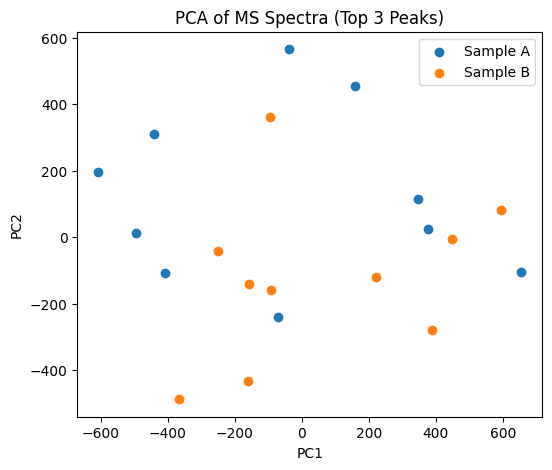

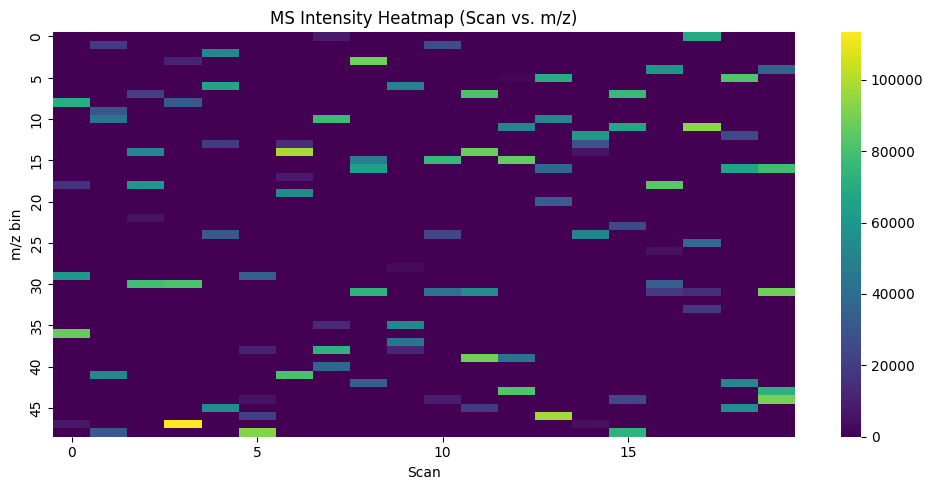

In [4]:
from sklearn.decomposition import PCA
import seaborn as sns

# --- Prepare feature matrix: use top N peaks per scan as features ---
N = 3  # Number of peaks per scan to use as features
features = []
for scan in range(time_points):
    scan_peaks = ms_df[ms_df['scan'] == scan].sort_values('intensity', ascending=False)
    top_mz = scan_peaks['mz'].values[:N]
    # Pad with zeros if fewer than N peaks
    if len(top_mz) < N:
        top_mz = np.pad(top_mz, (0, N - len(top_mz)), 'constant')
    features.append(top_mz)
features = np.array(features)

# --- PCA ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

plt.figure(figsize=(6, 5))
for label in np.unique(type_labels):
    idx = np.array(type_labels) == label
    plt.scatter(pca_result[idx, 0], pca_result[idx, 1], label=f'Sample {label}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of MS Spectra (Top 3 Peaks)')
plt.legend()
plt.show()

# --- Heatmap: Intensity vs. scan and m/z bins ---
mz_bins = np.linspace(mz_min, mz_max, 50)
scan_bins = np.arange(time_points + 1)
heatmap, xedges, yedges = np.histogram2d(ms_df['scan'], ms_df['mz'], bins=[scan_bins, mz_bins], weights=ms_df['intensity'])

plt.figure(figsize=(10, 5))
sns.heatmap(heatmap.T, cmap='viridis', xticklabels=5, yticklabels=5)
plt.xlabel('Scan')
plt.ylabel('m/z bin')
plt.title('MS Intensity Heatmap (Scan vs. m/z)')
plt.tight_layout()
plt.show()

### Interpreting the PCA of MS Spectra (Top 3 Peaks)

The PCA plot above visualizes each MS scan as a point in a 2D space, using the top 3 most intense m/z values from each scan as features. Points are colored by simulated sample type:

- **Sample A**: Scans where the top m/z peaks were shifted (simulating a different sample or condition)
- **Sample B**: Scans with unshifted peaks

This demonstrates how PCA can separate and cluster samples based on their spectral features, even with simple synthetic data. The approach is commonly used in MS data analysis for exploratory data analysis, quality control, and biomarker discovery.